In [76]:
# 04_log_prediction

In [77]:
# Force to reload extrernal modules every new cell execution
%reload_ext autoreload
%autoreload 2

In [78]:
### IMPORT ###
from pathlib import Path
from datetime import datetime
import pandas as pd
import re
# plot
import matplotlib.pyplot as plt
# ML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from xgboost import XGBRegressor
# XAI
import shap


In [79]:
### LOCAL IMPORT ###
from config import config_reader
from utilities import extract_files, convert_seconds_to_hours

In [80]:
### GLOBALS ###
yaml_config = config_reader.config_read_yaml("config.yml", "config")

dic_types = {"CaseID":object,  "TIMESTAMP":object, "ESI": int, "CASE_DURATION_sec": float, "REMAINING_TIME_sec":float} # <-- INPUT: columns types

encoding_dir = str(yaml_config["LOG_ENCODING_DIR"]) # <-- INPUT: the directory with files encoded for the ML models

# ML
ml_dir = str(yaml_config["ML_DIR"]) # <-- INPUT: the directoryin which to save ML results
label_column = "REMAINING_TIME_sec" # <-- INPUT: label for prediction
drop_column = ["CaseID", "TIMESTAMP"]  # <-- INPUT: columns to drop
cv_folds = 5 # <-- INPUT: number of folds for Cross Validation

# FUNCTIONS

In [81]:
def plot_custom_distribution(dataframe: pd.DataFrame, x_column: str, y_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color='skyblue')
    plt.title(f'Distribution of {y_column} by {x_column}')
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [82]:
def plot_custom_distribution_with_colours(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str) -> None:
    """
    This function takes a dataframe as input and displays a bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    """
    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract the data
    x_values = dataframe[x_column]
    y_values = dataframe[y_column]
    encoding_values = dataframe[encoding_column]

    # Create a colour map
    colours = encoding_values.map({'B': 'skyblue', 'F': 'lightgreen'})

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values, color=colours)
    plt_title = f"Distribution of '{y_column}' by '{x_column}'"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(handles=[
        plt.Line2D([0], [0], color='skyblue', lw=4, label='B'),
        plt.Line2D([0], [0], color='lightgreen', lw=4, label='F')
    ], title=encoding_column)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [97]:
def plot_custom_distribution_side_by_side(dataframe: pd.DataFrame, x_column: str, y_column: str, encoding_column: str, model_name:str) -> None:
    """
    This function takes a dataframe as input and displays a side-by-side bar chart of the actual values
    for the specified columns, using distinct colours based on the encoding column.

    Parameters:
    dataframe (pd.DataFrame): The input dataframe containing the columns to plot.
    x_column (str): The name of the column to use for the x-axis.
    y_column (str): The name of the column to use for the y-axis.
    encoding_column (str): The name of the column that determines the colour encoding.
    model_name (str): The name of the model used.
    """

    # Check that the specified columns exist in the dataframe
    if x_column not in dataframe.columns or y_column not in dataframe.columns or encoding_column not in dataframe.columns:
        raise ValueError("The specified columns do not exist in the dataframe.")
    
    # Extract unique values
    unique_x_values = dataframe[x_column].unique()
    unique_encodings = dataframe[encoding_column].unique()
    
    # Calculate width for each bar
    bar_width = 0.25  # Width of each bar
    index = np.arange(len(unique_x_values))  # The x locations for the groups

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot bars for each encoding
    for i, encoding in enumerate(unique_encodings):
        subset = dataframe[dataframe[encoding_column] == encoding]
        # Align the bars in each group
        plt.bar(index + i * bar_width, subset[y_column], bar_width, label=f'Encoding {encoding}')

    # Add titles and labels
    plt_title = f"Distribution of '{y_column}' by '{x_column}' \n Model: {model_name}"
    plt.title(plt_title)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.xticks(index + bar_width / 2, unique_x_values, rotation=45)
    plt.legend(title=encoding_column)
    plt.grid(axis='y')

    # Show the plot
    plt.tight_layout()
    plt.show()

In [84]:
def perform_regression_rfr(X_train: pd.DataFrame, y_train: pd.Series, X_test:pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name:str, prefix:str, encoding:str, cv_folds: int = 5) -> dict:
    """
    Perform regression using Random Forest and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing RFR")
    # Training
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # r2 = r2_score(y_test, y_pred)

    print("RMSE:", rmse)

    print("> CV validation")
    
    print("Folds:", cv_folds)

    # Scorer define for l'RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross validation to 5 folds
    cv_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convertire i valori negativi in positivi per ottenere l'RMSE
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
    "Model": "RFR",
    "File": file_name,
    "Prefix (h)": prefix,
    "Encoding": encoding,
    "RMSE_Before_CV_s": rmse,
    "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
    "CV_RMSE_Mean_s": cv_rmse_mean,
    "CV_RMSE_Std_s": cv_rmse_std,
    "CV_RMSE_Mean_m": cv_rmse_mean_m,
    "CV_RMSE_Std_m": cv_rmse_std_m
    }

    return results_dict

In [85]:
def perform_regression_xgr(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, target: pd.Series, df_log_ml_features: pd.DataFrame, file_name: str, prefix: str, encoding: str, cv_folds: int = 5) -> dict:
    """
    Perform regression using XGBoost and evaluate the model with RMSE.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target variable.
        X_test (pd.DataFrame): Test features.
        y_test (pd.Series): Test target variable.
        target (pd.Series): Target variable for cross-validation.
        df_log_ml_features (pd.DataFrame): Complete features for cross-validation.
        file_name (str): Name of the file.
        prefix (str): Prefix for the model.
        encoding (str): Encoding type.
        cv_folds (int): Number of cross-validation folds.

    Returns:
        dict: A dictionary containing the evaluation metrics.
    """
    print(">> Performing XGBoost Regression")

    # Training the model
    xgb_regressor = XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
    xgb_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = xgb_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print("RMSE:", rmse)

    print("> CV validation")
    print("Folds:", cv_folds)

    # Scorer defined for RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross-validation
    cv_scores = cross_val_score(xgb_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convert negative RMSE scores to positive values
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
        "Model": "XGR",
        "File": file_name,
        "Prefix (h)": prefix,
        "Encoding": encoding,
        "RMSE_Before_CV_s": rmse,
        "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
        "CV_RMSE_Mean_s": cv_rmse_mean,
        "CV_RMSE_Std_s": cv_rmse_std,
        "CV_RMSE_Mean_m": cv_rmse_mean_m,
        "CV_RMSE_Std_m": cv_rmse_std_m
    }

    return results_dict

# MAIN

In [86]:
### MAIN ###
print()
print("*** PROGRAM START ***")
print()

start_time = datetime.now().replace(microsecond=0)
print("Start process:", str(start_time))
print()

# print(yaml_config) # debug


*** PROGRAM START ***

Start process: 2024-08-03 15:04:47



In [87]:
print(">> Creating output directories")
directory_path = Path(ml_dir) # <-- Specify the directory to be created
# Create the directory
directory_path.mkdir(parents=True, exist_ok=True)
print(f"Directory '{directory_path}' created successfully.")

>> Creating output directories
Directory 'data_ml' created successfully.


In [88]:
print(">> Listing event log prefixes files")
list_files = extract_files(encoding_dir, "csv")
list_files_len = len(list_files)
print("Files found:", list_files_len)
print("Files found:", list_files)

>> Listing event log prefixes files
Files found: 9
Files found: ['EVENT-LOG_ED_duration_prefix_1h_B.csv', 'EVENT-LOG_ED_duration_prefix_1h_F.csv', 'EVENT-LOG_ED_duration_prefix_1h_I.csv', 'EVENT-LOG_ED_duration_prefix_2h_B.csv', 'EVENT-LOG_ED_duration_prefix_2h_F.csv', 'EVENT-LOG_ED_duration_prefix_2h_I.csv', 'EVENT-LOG_ED_duration_prefix_3h_B.csv', 'EVENT-LOG_ED_duration_prefix_3h_F.csv', 'EVENT-LOG_ED_duration_prefix_3h_I.csv']


In [89]:
list_results_ml = []
print(">> Reading event log prefixes files and applying ML models")
for file_name in list_files:
    path_data = Path(encoding_dir) / file_name
    print("File:", path_data)

    match = re.search(r'_(\d+)h_([A-Z])', file_name)
    prefix = match.group(1)
    encoding = match.group(2)
    print("Prefix:", prefix)
    print("Encoding:", encoding)

    df_log = pd.read_csv(path_data, sep=";", dtype=dic_types)
    print("Event log shape:", df_log.shape)
    print("Event log cases:", df_log["CaseID"].nunique())
    print(df_log.columns) # debug

    print("> Removing columns")
    print(drop_column)
    df_log_ml = df_log.drop(drop_column, axis=1)

    print("> Preparing data for regression")
    df_log_ml_features = df_log_ml.drop(columns=['REMAINING_TIME_sec'], axis=1) # Final features as input to the model
    
    # Select the "label"
    target = df_log_ml[label_column]

    # Training and Test split
    X_train, X_test, y_train, y_test = train_test_split(df_log_ml_features, target, test_size=0.2, random_state=42)

    """
    # Training
    rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_regressor.fit(X_train, y_train)

    # Test the training
    y_pred = rf_regressor.predict(X_test)

    # Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # r2 = r2_score(y_test, y_pred)

    print("RMSE:", rmse)

    print("> CV validation")
    
    print("Folds:", cv_folds)

    # Scorer define for l'RMSE (negative since cross_val_score minimises the score)
    neg_rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

    # Cross validation to 5 folds
    cv_scores = cross_val_score(rf_regressor, df_log_ml_features, target, cv=cv_folds, scoring=neg_rmse_scorer)

    # Convertire i valori negativi in positivi per ottenere l'RMSE
    cv_rmse_scores = -cv_scores
    cv_rmse_mean = cv_rmse_scores.mean()
    cv_rmse_std = cv_rmse_scores.std()

    cv_rmse_mean_m, cv_rmse_mean_h = convert_seconds_to_hours(cv_rmse_mean)
    cv_rmse_std_m, cv_rmse_std_h = convert_seconds_to_hours(cv_rmse_std)

    print(f"RMSE of every fold in seconds: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean}, RMSE std: {cv_rmse_std}")
    print(f"RMSE mean of every fold in minutes: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_m}, RMSE std: {cv_rmse_std_m}")
    print(f"RMSE mean of every fold in hours: {cv_rmse_scores}, RMSE mean: {cv_rmse_mean_h}, RMSE std: {cv_rmse_std_h}")

    results_dict = {
    "Model": "RFR",
    "File": file_name,
    "Prefix (h)": prefix,
    "Encoding": encoding,
    "RMSE_Before_CV_s": rmse,
    "CV_RMSE_Scores_s": cv_rmse_scores.tolist(),
    "CV_RMSE_Mean_s": cv_rmse_mean,
    "CV_RMSE_Std_s": cv_rmse_std,
    "CV_RMSE_Mean_m": cv_rmse_mean_m,
    "CV_RMSE_Std_m": cv_rmse_std_m
    }
    """

    results_dict = perform_regression_rfr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, prefix, encoding, 5)
    list_results_ml.append(results_dict)

    results_dict = perform_regression_xgr(X_train, y_train, X_test, y_test, target, df_log_ml_features, file_name, prefix, encoding, 5)
    list_results_ml.append(results_dict)
    
    print("-"*8)

>> Reading event log prefixes files and applying ML models
File: data_encoding/EVENT-LOG_ED_duration_prefix_1h_B.csv
Prefix: 1
Encoding: B
Event log shape: (11289, 187)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP',
       'ACTIVITY_altra_intubazione_del_tratto_respiratorio__inserzione_stent_',
       'ACTIVITY_altri_interventi_sulla_trachea',
       'ACTIVITY_arcata_dentaria_completa__sup_o_inf_',
       'ACTIVITY_asportazione_o_demolizione_endoscopica_di_lesione_o_tessuto_nei_bronchi',
       'ACTIVITY_broncoscopia_con_fibre_ottiche',
       'ACTIVITY_broncoscopia_rigida', 'ACTIVITY_consulenza',
       'ACTIVITY_controlli_pretrasf_',
       ...
       'INPAT-HOSP-DEP_ortopedia_e_traumatologia_ro',
       'INPAT-HOSP-DEP_pneumologia_ro__no_covid__',
       'INPAT-HOSP-DEP_psichiatria_ro', 'INPAT-HOSP-DEP_rianimazione_covid',
       'INPAT-HOSP-DEP_s_s__u_t_i_c__ro',
       'INPAT-HOSP-DEP_terapia_onco_ematologica_intensiva_trapianto_ro',
       'INPAT-HOSP-DEP_urologia_ro', 'ESI'

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1291.26865314  890.61562419 1155.66975266  976.20596089 1100.80655668], RMSE mean: 1082.9133095125546, RMSE std: 139.56394631985285
RMSE mean of every fold in minutes: [1291.26865314  890.61562419 1155.66975266  976.20596089 1100.80655668], RMSE mean: 18.048555158542577, RMSE std: 2.3260657719975475
RMSE mean of every fold in hours: [1291.26865314  890.61562419 1155.66975266  976.20596089 1100.80655668], RMSE mean: 0.3008092526423763, RMSE std: 0.03876776286662579
>> Performing XGBoost Regression
RMSE: 2351.1463731816993
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4731.62995134 2223.59939505 3552.5988806  4533.55472154 7336.29726986], RMSE mean: 4475.536043678008, RMSE std: 1683.8014565957253
RMSE mean of every fold in minutes: [4731.62995134 2223.59939505 3552.5988806  4533.55472154 7336.29726986], RMSE mean: 74.59226739463347, RMSE std: 28.063357609928754
RMSE mean of every fold in hours: [4731.62995134 2223.59939505 3552.5988806  4533.55472154 7336.29726986], RMSE mean: 1.2432044565772244, RMSE std: 0.4677226268321459
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_1h_F.csv
Prefix: 1
Encoding: F
Event log shape: (11289, 187)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP', 'ACTIVITY_triage', 'ACTIVITY_presa_in_carico',
       'ACTIVITY_laboratorio', 'ACTIVITY_tc_cranio', 'ACTIVITY_tac',
       'ACTIVITY_consulenza', 'ACTIVITY_rx', 'ACTIVITY_dimissione',
       ...
       'INPAT-HOSP-DEP_ortopedia_e_traumatologia_ro',
       'INPAT-HOSP-DEP_pneumologia_ro__no_covid__',
       'INPAT-HOSP-DEP_psichia

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1282.73582014  862.09036394 1155.35899142 1011.12438434 1090.10059813], RMSE mean: 1080.2820315946728, RMSE std: 140.79124592647477
RMSE mean of every fold in minutes: [1282.73582014  862.09036394 1155.35899142 1011.12438434 1090.10059813], RMSE mean: 18.00470052657788, RMSE std: 2.3465207654412463
RMSE mean of every fold in hours: [1282.73582014  862.09036394 1155.35899142 1011.12438434 1090.10059813], RMSE mean: 0.30007834210963136, RMSE std: 0.03910867942402077
>> Performing XGBoost Regression
RMSE: 2480.6682636093415
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4485.5378229  2120.41778143 3226.6876444  4682.8855978  7157.25702309], RMSE mean: 4334.5571739253755, RMSE std: 1687.6937180415473
RMSE mean of every fold in minutes: [4485.5378229  2120.41778143 3226.6876444  4682.8855978  7157.25702309], RMSE mean: 72.24261956542293, RMSE std: 28.12822863402579
RMSE mean of every fold in hours: [4485.5378229  2120.41778143 3226.6876444  4682.8855978  7157.25702309], RMSE mean: 1.2040436594237154, RMSE std: 0.46880381056709647
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_1h_I.csv
Prefix: 1
Encoding: I
Event log shape: (11289, 187)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP', 'ACTIVITY_triage', 'ACTIVITY_presa_in_carico',
       'ACTIVITY_laboratorio', 'ACTIVITY_tc_cranio', 'ACTIVITY_tac',
       'ACTIVITY_consulenza', 'ACTIVITY_rx', 'ACTIVITY_dimissione',
       ...
       'INPAT-HOSP-DEP_ortopedia_e_traumatologia_ro',
       'INPAT-HOSP-DEP_pneumologia_ro__no_covid__',
       'INPAT-HOSP-DEP_psichi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1279.14219099  883.08577488 1166.91780649  963.15352261 1147.9377882 ], RMSE mean: 1088.047416635581, RMSE std: 144.17514844533113
RMSE mean of every fold in minutes: [1279.14219099  883.08577488 1166.91780649  963.15352261 1147.9377882 ], RMSE mean: 18.134123610593015, RMSE std: 2.402919140755519
RMSE mean of every fold in hours: [1279.14219099  883.08577488 1166.91780649  963.15352261 1147.9377882 ], RMSE mean: 0.3022353935098836, RMSE std: 0.04004865234592532
>> Performing XGBoost Regression
RMSE: 2564.9970445448494
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4505.97948343 2215.7724102  3408.36409878 4676.82296911 7503.67606859], RMSE mean: 4462.123006022055, RMSE std: 1758.1560414894907
RMSE mean of every fold in minutes: [4505.97948343 2215.7724102  3408.36409878 4676.82296911 7503.67606859], RMSE mean: 74.36871676703426, RMSE std: 29.302600691491513
RMSE mean of every fold in hours: [4505.97948343 2215.7724102  3408.36409878 4676.82296911 7503.67606859], RMSE mean: 1.2394786127839044, RMSE std: 0.4883766781915252
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_2h_B.csv
Prefix: 2
Encoding: B
Event log shape: (14087, 202)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP',
       'ACTIVITY_altra_intubazione_del_tratto_respiratorio__inserzione_stent_',
       'ACTIVITY_altri_interventi_sulla_trachea',
       'ACTIVITY_arcata_dentaria_completa__sup_o_inf_',
       'ACTIVITY_asportazione_o_demolizione_endoscopica_di_lesione_o_tessuto_nei_bronchi',
       'ACTIVITY_bicarbonato_dialisi',
       'ACTIVIT

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1733.11874313 1487.63396573 1687.44102087 1612.50777807 1599.92630582], RMSE mean: 1624.125562725473, RMSE std: 83.9510495724693
RMSE mean of every fold in minutes: [1733.11874313 1487.63396573 1687.44102087 1612.50777807 1599.92630582], RMSE mean: 27.068759378757882, RMSE std: 1.399184159541155
RMSE mean of every fold in hours: [1733.11874313 1487.63396573 1687.44102087 1612.50777807 1599.92630582], RMSE mean: 0.4511459896459647, RMSE std: 0.023319735992352583
>> Performing XGBoost Regression
RMSE: 2198.188450932736
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4684.27653175 2597.46534526 3334.79667736 4399.80093941 6298.41915744], RMSE mean: 4262.951730242165, RMSE std: 1262.9082818913896
RMSE mean of every fold in minutes: [4684.27653175 2597.46534526 3334.79667736 4399.80093941 6298.41915744], RMSE mean: 71.04919550403608, RMSE std: 21.048471364856493
RMSE mean of every fold in hours: [4684.27653175 2597.46534526 3334.79667736 4399.80093941 6298.41915744], RMSE mean: 1.1841532584006014, RMSE std: 0.35080785608094156
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_2h_F.csv
Prefix: 2
Encoding: F
Event log shape: (14087, 202)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP', 'ACTIVITY_triage', 'ACTIVITY_presa_in_carico',
       'ACTIVITY_laboratorio', 'ACTIVITY_tc_cranio', 'ACTIVITY_tac',
       'ACTIVITY_dimissione', 'ACTIVITY_consulenza', 'ACTIVITY_rx',
       ...
       'INPAT-HOSP-DEP_ortopedia_e_traumatologia_ro',
       'INPAT-HOSP-DEP_pneumologia_ro__no_covid__',
       'INPAT-HOSP-DEP_psichi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1665.93383319 1361.83106324 1636.32868758 1589.5928133  1495.02166169], RMSE mean: 1549.7416117989792, RMSE std: 110.35462787547611
RMSE mean of every fold in minutes: [1665.93383319 1361.83106324 1636.32868758 1589.5928133  1495.02166169], RMSE mean: 25.82902686331632, RMSE std: 1.839243797924602
RMSE mean of every fold in hours: [1665.93383319 1361.83106324 1636.32868758 1589.5928133  1495.02166169], RMSE mean: 0.43048378105527196, RMSE std: 0.030654063298743366
>> Performing XGBoost Regression
RMSE: 2121.0260378105313
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4712.30886374 2498.81366642 2851.18762823 4474.48522218 5369.36223537], RMSE mean: 3981.231523186828, RMSE std: 1111.6871925275307
RMSE mean of every fold in minutes: [4712.30886374 2498.81366642 2851.18762823 4474.48522218 5369.36223537], RMSE mean: 66.35385871978046, RMSE std: 18.528119875458845
RMSE mean of every fold in hours: [4712.30886374 2498.81366642 2851.18762823 4474.48522218 5369.36223537], RMSE mean: 1.1058976453296743, RMSE std: 0.30880199792431406
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_2h_I.csv
Prefix: 2
Encoding: I
Event log shape: (14087, 202)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP', 'ACTIVITY_triage', 'ACTIVITY_presa_in_carico',
       'ACTIVITY_laboratorio', 'ACTIVITY_tc_cranio', 'ACTIVITY_tac',
       'ACTIVITY_dimissione', 'ACTIVITY_consulenza', 'ACTIVITY_rx',
       ...
       'INPAT-HOSP-DEP_ortopedia_e_traumatologia_ro',
       'INPAT-HOSP-DEP_pneumologia_ro__no_covid__',
       'INPAT-HOSP-DEP_psichi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [1703.2319121  1439.49653251 1679.13532783 1595.62283658 1623.06102654], RMSE mean: 1608.1095271125846, RMSE std: 92.63124658346992
RMSE mean of every fold in minutes: [1703.2319121  1439.49653251 1679.13532783 1595.62283658 1623.06102654], RMSE mean: 26.80182545187641, RMSE std: 1.5438541097244987
RMSE mean of every fold in hours: [1703.2319121  1439.49653251 1679.13532783 1595.62283658 1623.06102654], RMSE mean: 0.44669709086460685, RMSE std: 0.025730901828741645
>> Performing XGBoost Regression
RMSE: 2130.863368369403
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4677.92175833 2600.61659338 3375.93671054 4466.20588315 6237.01302967], RMSE mean: 4271.5387950120985, RMSE std: 1237.7572825714212
RMSE mean of every fold in minutes: [4677.92175833 2600.61659338 3375.93671054 4466.20588315 6237.01302967], RMSE mean: 71.19231325020164, RMSE std: 20.62928804285702
RMSE mean of every fold in hours: [4677.92175833 2600.61659338 3375.93671054 4466.20588315 6237.01302967], RMSE mean: 1.1865385541700273, RMSE std: 0.3438214673809503
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_3h_B.csv
Prefix: 3
Encoding: B
Event log shape: (15953, 207)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP',
       'ACTIVITY_altra_intubazione_del_tratto_respiratorio__inserzione_stent_',
       'ACTIVITY_altri_interventi_sulla_trachea',
       'ACTIVITY_arcata_dentaria_completa__sup_o_inf_',
       'ACTIVITY_asportazione_o_demolizione_endoscopica_di_lesione_o_tessuto_nei_bronchi',
       'ACTIVITY_bicarbonato_dialisi',
       'ACTIVIT

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [2405.31896488 2056.1515808  2422.43433181 2225.7356609  2422.854814  ], RMSE mean: 2306.4990704770607, RMSE std: 145.5620893737149
RMSE mean of every fold in minutes: [2405.31896488 2056.1515808  2422.43433181 2225.7356609  2422.854814  ], RMSE mean: 38.44165117461768, RMSE std: 2.4260348228952484
RMSE mean of every fold in hours: [2405.31896488 2056.1515808  2422.43433181 2225.7356609  2422.854814  ], RMSE mean: 0.6406941862436281, RMSE std: 0.040433913714920805
>> Performing XGBoost Regression
RMSE: 4143.691848193932
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4340.64799784 2321.81504153 5216.92762879 3917.85894309 6417.41993646], RMSE mean: 4442.933909541789, RMSE std: 1362.5690975731868
RMSE mean of every fold in minutes: [4340.64799784 2321.81504153 5216.92762879 3917.85894309 6417.41993646], RMSE mean: 74.04889849236315, RMSE std: 22.709484959553112
RMSE mean of every fold in hours: [4340.64799784 2321.81504153 5216.92762879 3917.85894309 6417.41993646], RMSE mean: 1.2341483082060525, RMSE std: 0.37849141599255187
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_3h_F.csv
Prefix: 3
Encoding: F
Event log shape: (15953, 207)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP', 'ACTIVITY_triage', 'ACTIVITY_presa_in_carico',
       'ACTIVITY_laboratorio', 'ACTIVITY_tc_cranio', 'ACTIVITY_tac',
       'ACTIVITY_dimissione', 'ACTIVITY_consulenza', 'ACTIVITY_rx',
       ...
       'INPAT-HOSP-DEP_ortopedia_e_traumatologia_ro',
       'INPAT-HOSP-DEP_pneumologia_ro__no_covid__',
       'INPAT-HOSP-DEP_psichi

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [2311.18500753 1918.14942048 2298.65211802 2134.53261342 2357.96881715], RMSE mean: 2204.0975953189454, RMSE std: 161.6726754440116
RMSE mean of every fold in minutes: [2311.18500753 1918.14942048 2298.65211802 2134.53261342 2357.96881715], RMSE mean: 36.73495992198242, RMSE std: 2.6945445907335266
RMSE mean of every fold in hours: [2311.18500753 1918.14942048 2298.65211802 2134.53261342 2357.96881715], RMSE mean: 0.6122493320330403, RMSE std: 0.04490907651222544
>> Performing XGBoost Regression
RMSE: 3841.7714182125646
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4113.06346721 2341.38813956 5135.64059068 4892.62083105 5683.9518084 ], RMSE mean: 4433.33296738232, RMSE std: 1161.6397496965021
RMSE mean of every fold in minutes: [4113.06346721 2341.38813956 5135.64059068 4892.62083105 5683.9518084 ], RMSE mean: 73.88888278970533, RMSE std: 19.360662494941703
RMSE mean of every fold in hours: [4113.06346721 2341.38813956 5135.64059068 4892.62083105 5683.9518084 ], RMSE mean: 1.2314813798284223, RMSE std: 0.32267770824902836
--------
File: data_encoding/EVENT-LOG_ED_duration_prefix_3h_I.csv
Prefix: 3
Encoding: I
Event log shape: (15953, 207)
Event log cases: 3478
Index(['CaseID', 'TIMESTAMP', 'ACTIVITY_triage', 'ACTIVITY_presa_in_carico',
       'ACTIVITY_laboratorio', 'ACTIVITY_tc_cranio', 'ACTIVITY_tac',
       'ACTIVITY_dimissione', 'ACTIVITY_consulenza', 'ACTIVITY_rx',
       ...
       'INPAT-HOSP-DEP_ortopedia_e_traumatologia_ro',
       'INPAT-HOSP-DEP_pneumologia_ro__no_covid__',
       'INPAT-HOSP-DEP_psichia

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [2364.73461435 2003.33325134 2392.26050258 2174.53033602 2402.19593278], RMSE mean: 2267.410927414109, RMSE std: 155.94238512337407
RMSE mean of every fold in minutes: [2364.73461435 2003.33325134 2392.26050258 2174.53033602 2402.19593278], RMSE mean: 37.790182123568485, RMSE std: 2.5990397520562345
RMSE mean of every fold in hours: [2364.73461435 2003.33325134 2392.26050258 2174.53033602 2402.19593278], RMSE mean: 0.6298363687261415, RMSE std: 0.04331732920093724
>> Performing XGBoost Regression
RMSE: 4036.090649479813
> CV validation
Folds: 5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_reg

RMSE of every fold in seconds: [4207.21542265 2246.99824036 5050.8226434  4479.74430032 6403.31234177], RMSE mean: 4477.618589702241, RMSE std: 1348.0095584404314
RMSE mean of every fold in minutes: [4207.21542265 2246.99824036 5050.8226434  4479.74430032 6403.31234177], RMSE mean: 74.62697649503734, RMSE std: 22.46682597400719
RMSE mean of every fold in hours: [4207.21542265 2246.99824036 5050.8226434  4479.74430032 6403.31234177], RMSE mean: 1.2437829415839556, RMSE std: 0.3744470995667865
--------


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [90]:
print("Creating ML results")
df_ml = pd.DataFrame.from_records(list_results_ml)
df_ml = df_ml.sort_values(by = ["File"])
df_ml

Creating ML results


,Model,File,Prefix (h),Encoding,RMSE_Before_CV_s,CV_RMSE_Scores_s,CV_RMSE_Mean_s,CV_RMSE_Std_s,CV_RMSE_Mean_m,CV_RMSE_Std_m
0,RFR,EVENT-LOG_ED_duration_prefix_1h_B.csv,1,B,647.858869,"[1291.2686531403756, 890.6156241914717, 1155.6...",1082.913310,139.563946,18.048555,2.326066
1,XGR,EVENT-LOG_ED_duration_prefix_1h_B.csv,1,B,2351.146373,"[4731.629951337902, 2223.5993950500165, 3552.5...",4475.536044,1683.801457,74.592267,28.063358
2,RFR,EVENT-LOG_ED_duration_prefix_1h_F.csv,1,F,600.014668,"[1282.7358201397906, 862.090363943882, 1155.35...",1080.282032,140.791246,18.004701,2.346521
3,XGR,EVENT-LOG_ED_duration_prefix_1h_F.csv,1,F,2480.668264,"[4485.537822902372, 2120.417781429895, 3226.68...",4334.557174,1687.693718,72.242620,28.128229
4,RFR,EVENT-LOG_ED_duration_prefix_1h_I.csv,1,I,647.957246,"[1279.1421909941673, 883.0857748813954, 1166.9...",1088.047417,144.175148,18.134124,2.402919
5,XGR,EVENT-LOG_ED_duration_prefix_1h_I.csv,1,I,2564.997045,"[4505.979483431365, 2215.7724101966664, 3408.3...",4462.123006,1758.156041,74.368717,29.302601
6,RFR,EVENT-LOG_ED_duration_prefix_2h_B.csv,2,B,1143.410730,"[1733.118743133765, 1487.6339657270762, 1687.4...",1624.125563,83.951050,27.068759,1.399184
7,XGR,EVENT-LOG_ED_duration_prefix_2h_B.csv,2,B,2198.188451,"[4684.276531746856, 2597.465345256367, 3334.79...",4262.951730,1262.908282,71.049196,21.048471
9,XGR,EVENT-LOG_ED_duration_prefix_2h_F.csv,2,F,2121.026038,"[4712.308863735031, 2498.813666415312, 2851.18...",3981.231523,1111.687193,66.353859,18.528120
8,RFR,EVENT-LOG_ED_duration_prefix_2h_F.csv,2,F,1008.519023,"[1665.9338331944825, 1361.8310632360863, 1636....",1549.741612,110.354628,25.829027,1.839244


In [94]:
# Select rows by model
df_ml_rfr = df_ml[df_ml["Model"] == "RFR"]
df_ml_xgr = df_ml[df_ml["Model"] == "XGR"]

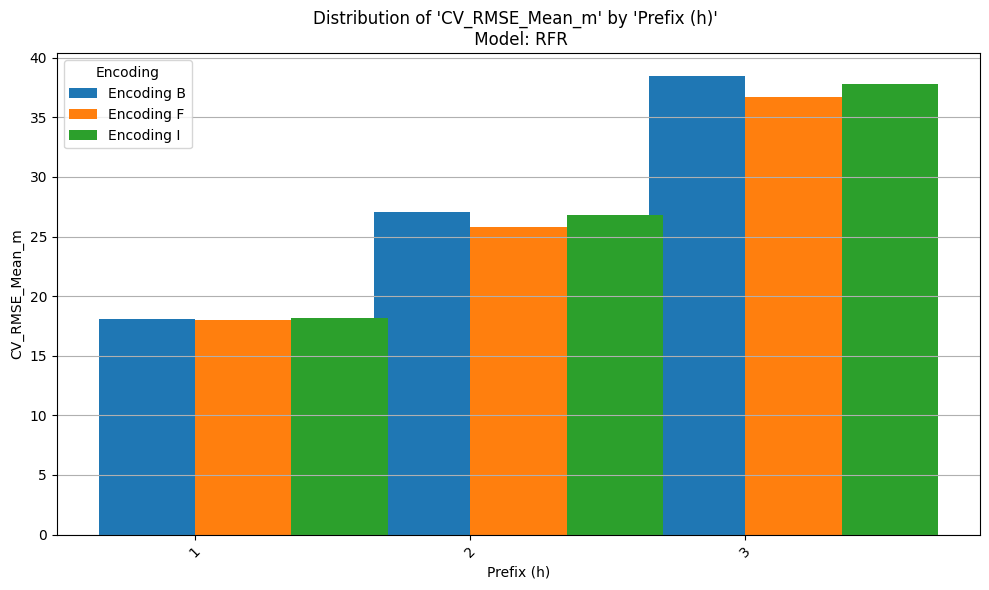

In [99]:
plot_custom_distribution_side_by_side(df_ml_rfr, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", "RFR")

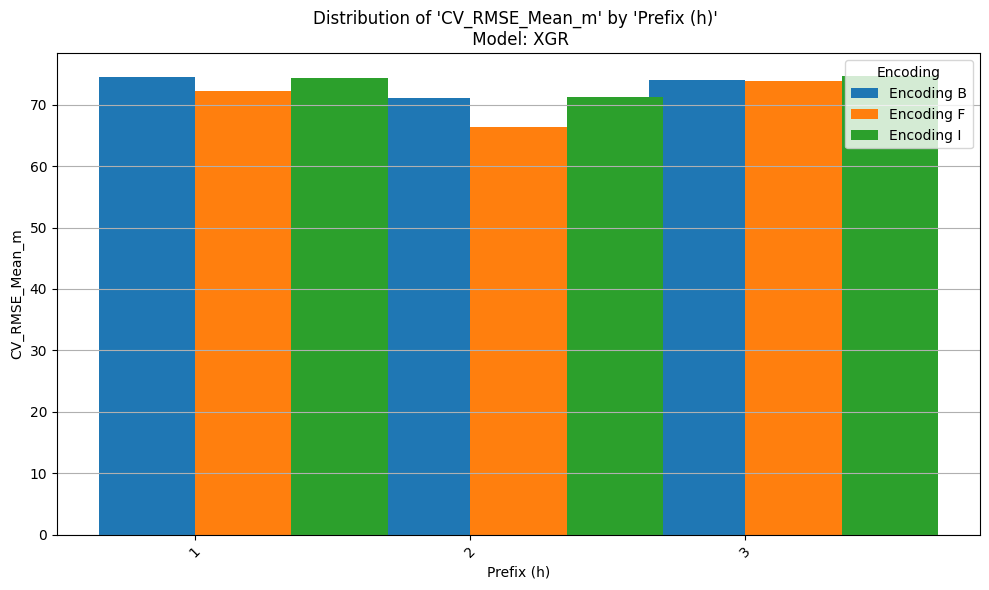

In [100]:
plot_custom_distribution_side_by_side(df_ml_xgr, "Prefix (h)", "CV_RMSE_Mean_m", "Encoding", "XGR")

In [92]:
print(">> Saving ML results")

path_out = Path(ml_dir) / "ML_ensemble_results.csv"
print("File:", path_out)
df_ml.to_csv(path_out, sep=";", index=False)

path_out = Path(ml_dir) / "ML_ensemble_results.xlsx"
print("File:", path_out)
df_ml.to_excel(path_out, index=False, sheet_name="ML_ensemble_results")

>> Saving ML results
File: data_ml/ML_ensemble_results.csv
File: data_ml/ML_ensemble_results.xlsx


In [93]:
# program end
end_time = datetime.now().replace(microsecond=0)
delta_time = end_time - start_time

print("End process:", end_time)
print("Time to finish:", delta_time)

print()
print("*** PROGRAM END ***")
print()

End process: 2024-08-03 15:08:43
Time to finish: 0:03:56

*** PROGRAM END ***

